In [1]:
# Basic packages
import pandas as pd
import numpy as np

# Package for NLP
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

# Package for visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Packages for evalution
## ROUGE score
from rouge import Rouge

# Other packages
import textwrap

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zionsheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1: Load datasets

In [2]:
# Read dataset.
def load_dataset(dataset_path: str) -> pd.DataFrame:
    df = pd.read_csv(dataset_path)
    df.dropna(inplace=True) # Drop null values (if any)
    return df

In [3]:
df_train = load_dataset(r'../data/cnn_dailymail/train.csv')
df_train['highlights'] = df_train['highlights'].str.replace('\n', ' ', regex=True)
df_train['highlights'] = df_train['highlights'].str.replace(' \.', '.', regex=True)

df_val = load_dataset(r'../data/cnn_dailymail/validation.csv')
df_val['highlights'] = df_val['highlights'].str.replace('\n', ' ', regex=True)
df_val['highlights'] = df_val['highlights'].str.replace(' \.', '.', regex=True)

df_test = load_dataset(r'../data/cnn_dailymail/test.csv')
df_test['highlights'] = df_test['highlights'].str.replace('\n', ' ', regex=True)
df_test['highlights'] = df_test['highlights'].str.replace(' \.', '.', regex=True)

## Step 2: Implement baseline summarizer (TF-IDF sum)

In [4]:
def summarize(text: str, summary_len: int) -> str:
    """ Extract sentences from text as the summary using TF-IDF scoring.

    Parameters:
        - text (str): a string of text needs to be summarized.
        - summary_len (int): number of sentences in the summary.

    Returns:
        summary (str): a string of summary

    Notes:
        The score for each sentence is the average TF-IDF score of words (tokens)
        whose score is not zero.
    """
    # Initialize a TF-IDF Vectorizer.
    stop_words = stopwords.words('english')
    tfidf = TfidfVectorizer(stop_words=stop_words, norm='l1')
    # Tokenize sentences (ie, split text into individual sentences).
    sents = nltk.tokenize.sent_tokenize(text)
    # Remove overly short sentences.
    sent_lens = [len(sent) for sent in sents]
    avg_sent_len = sum(sent_lens) / len(sent_lens)
    sents = [sent for sent in sents if len(sent) > avg_sent_len * 0.5]
    # Perform TF-IDF.
    X = tfidf.fit_transform(sents)
    # Compute each sentence score.
    scores = np.zeros(len(sents))
    for i in range(len(sents)):
        score = X[i,:][X[i,:] != 0].mean()
        scores[i] = score

    # Sort the scores.
    sort_idx = np.argsort(-scores)
    # Concatenate sentences with top scores as the summary.
    summary = ''
    for i in sort_idx[:summary_len]:
        summary += (sents[i] + ' ')
    return summary

## Step 3. Qualitative Investigation

In [5]:
# Print the generated summary for an example article.
summarize(df_train['article'][0], 4)

'Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located . The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. Symptoms of hepatitis A include fever, tiredness, loss of appetite, nausea and abdominal discomfort. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. '

## Step 4. Infer on Testset

In [7]:
try:
    results = pd.read_csv('./pred/TFIDFsum.csv')
except:
    results = pd.DataFrame(data=df_test[['id', 'highlights']])
    results.rename(columns={'highlights':'actual_summary'}, inplace=True)
    results['pred_summary'] = df_test.apply(lambda row:
                                            summarize(row.article, 4),
                                            axis=1)
    rouge = Rouge()
    rouge_scores = rouge.get_scores(hyps=results['pred_summary'],
                                    refs=results['actual_summary'])
    results['rogue1_f1'] = [record['rouge-1']['f']for record in rouge_scores]
    results['rogue2_f1'] = [record['rouge-2']['f']for record in rouge_scores]
    results['rogueL_f1'] = [record['rouge-l']['f']for record in rouge_scores]
    results.to_csv('./pred/TFIDFsum.csv', index=False)

/Users/zionsheng/miniconda3/lib/python3.11/site-packages/scipy/sparse/_base.py:645: RuntimeWarning: divide by zero encountered in divide
  return self.astype(np.float_)._mul_scalar(1./other)


## Step 5. Quantitative Investigation

In [8]:
rouge1_f1 = results['rogue1_f1']
rouge2_f1 = results['rogue2_f1']
rougeL_f1 = results['rogueL_f1']
avg_rouge1_f1 = rouge1_f1.mean()
avg_rouge2_f1 = rouge2_f1.mean()
avg_rougeL_f1 = rougeL_f1.mean()

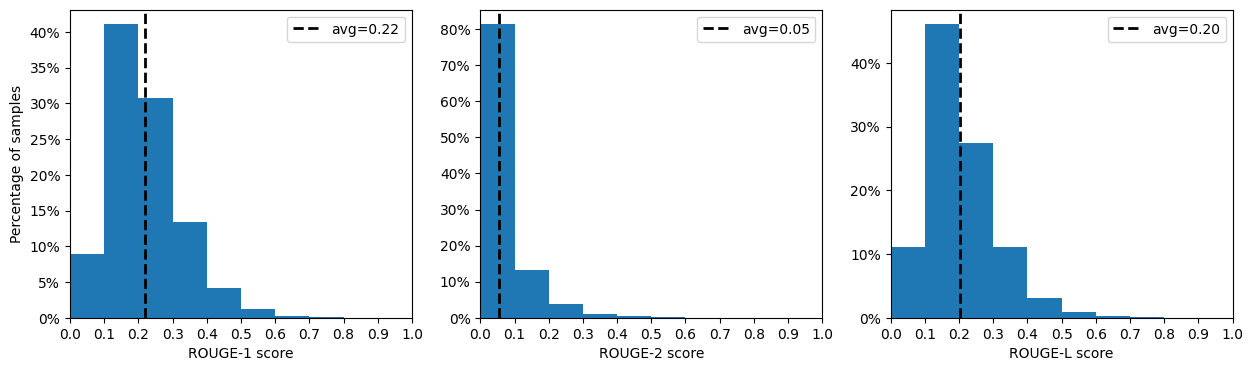

In [9]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(rouge1_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rouge1_f1))/len(rouge1_f1))
plt.axvline(x=avg_rouge1_f1, ls='--', lw=2, c='black', label=f'avg={avg_rouge1_f1:.2f}')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-1 score')
plt.ylabel('Percentage of samples')

plt.subplot(1, 3, 2)
plt.hist(rouge2_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rouge2_f1))/len(rouge2_f1))
plt.axvline(x=avg_rouge2_f1, ls='--', lw=2, c='black', label=f'avg={avg_rouge2_f1:.2f}')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-2 score')

plt.subplot(1, 3, 3)
plt.hist(rougeL_f1, bins=[0.1*i for i in range(11)],
         weights=np.ones(len(rougeL_f1))/len(rougeL_f1))
plt.axvline(x=avg_rougeL_f1, ls='--', lw=2, c='black', label=f'avg={avg_rougeL_f1:.2f}')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.xticks([0.1*i for i in range(11)])
plt.xlabel('ROUGE-L score')

plt.show()